In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: set plotting style
sns.set(style="whitegrid")

In [2]:
# Load merged dataset
df = pd.read_csv("../../dataset/processed/merged_gold_macro_final.csv", parse_dates=["Date"])

# Clean 'Volume' column
df["Volume"] = pd.to_numeric(df["Volume"].astype(str).str.replace(",", ""), errors="coerce")


# Set Date as index for easier time series analysis
df.set_index("Date", inplace=True)

# Quick overview
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2764 entries, 2014-01-02 to 2024-12-30
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            2764 non-null   float64
 1   High            2764 non-null   float64
 2   Low             2764 non-null   float64
 3   Close           2764 non-null   float64
 4   Adj_Close       2764 non-null   float64
 5   Volume          2730 non-null   float64
 6   USD_Index       2764 non-null   float64
 7   CPI             2764 non-null   float64
 8   Yield_10Y       2764 non-null   float64
 9   headline_count  2764 non-null   int64  
 10  avg_sentiment   2764 non-null   float64
 11  std_sentiment   2764 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 280.7 KB


,Open,High,Low,Close,Adj_Close,Volume,USD_Index,CPI,Yield_10Y,headline_count,avg_sentiment,std_sentiment
Date,,,,,,,,,,,,
2014-01-02,1204.3,1227.3,1204.3,1225.0,1225.0,209.0,80.63,236.468,3.00,1,-0.4404,0.0
2014-01-03,1221.7,1239.0,1221.7,1238.4,1238.4,142.0,80.79,236.468,3.01,2,0.0000,0.0
2014-01-06,1232.8,1247.0,1221.9,1237.8,1237.8,127.0,80.65,236.468,2.98,1,0.7430,0.0
2014-01-07,1239.3,1242.4,1226.3,1229.4,1229.4,73.0,80.83,236.468,2.96,1,0.0000,0.0
2014-01-08,1227.5,1227.5,1218.6,1225.3,1225.3,189.0,81.04,236.468,3.01,1,0.0000,0.0


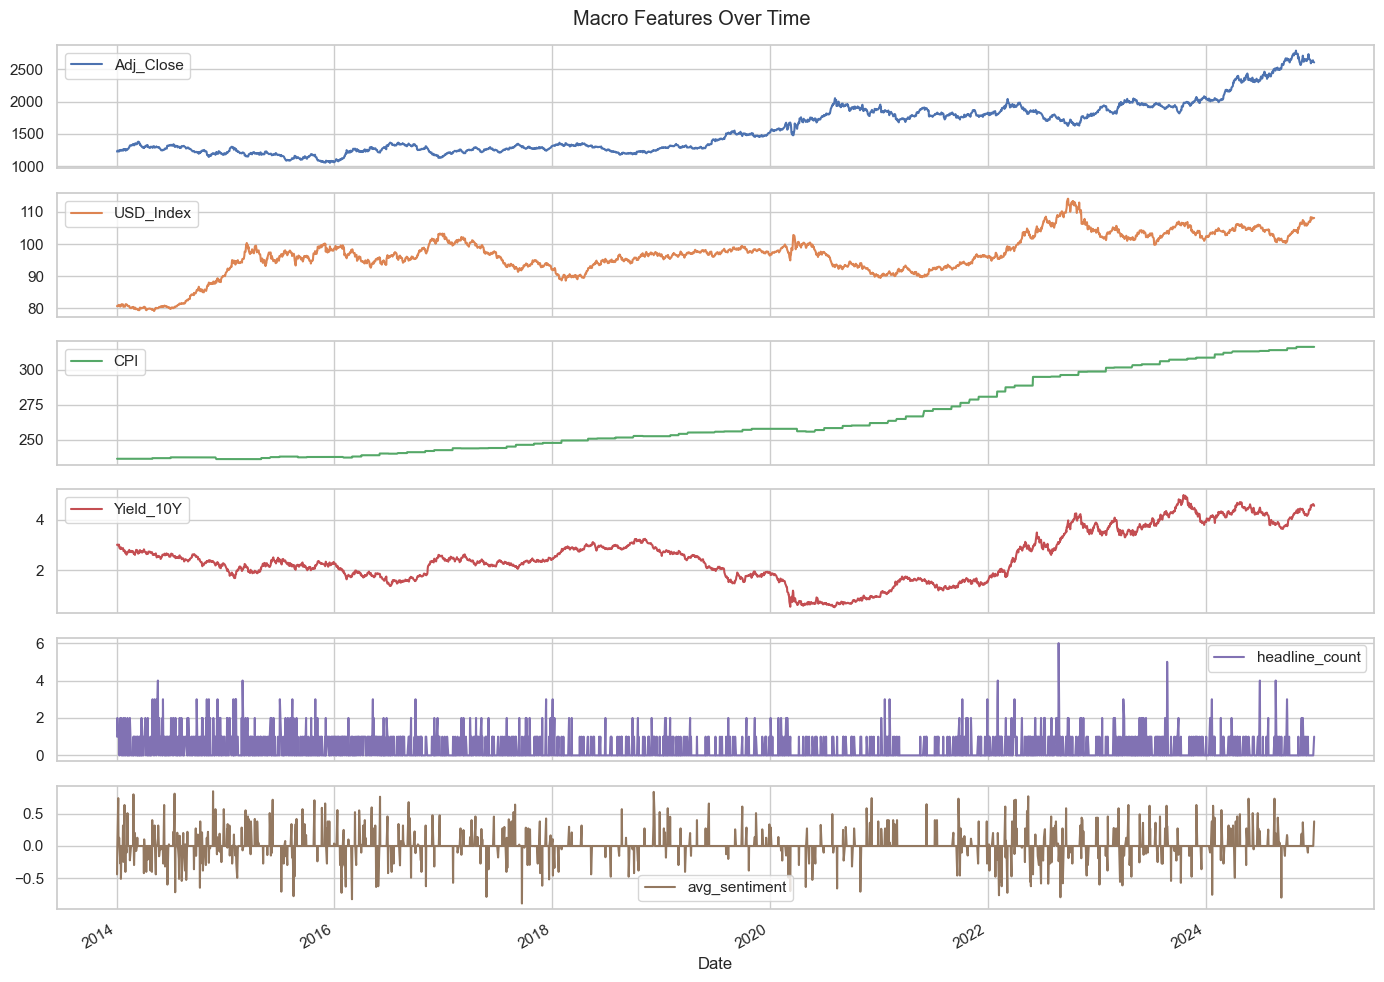

In [3]:
df[["Adj_Close", "USD_Index", "CPI", "Yield_10Y", "headline_count", "avg_sentiment"]].plot(subplots=True, figsize=(14, 10), title="Macro Features Over Time")
plt.tight_layout()
plt.show()

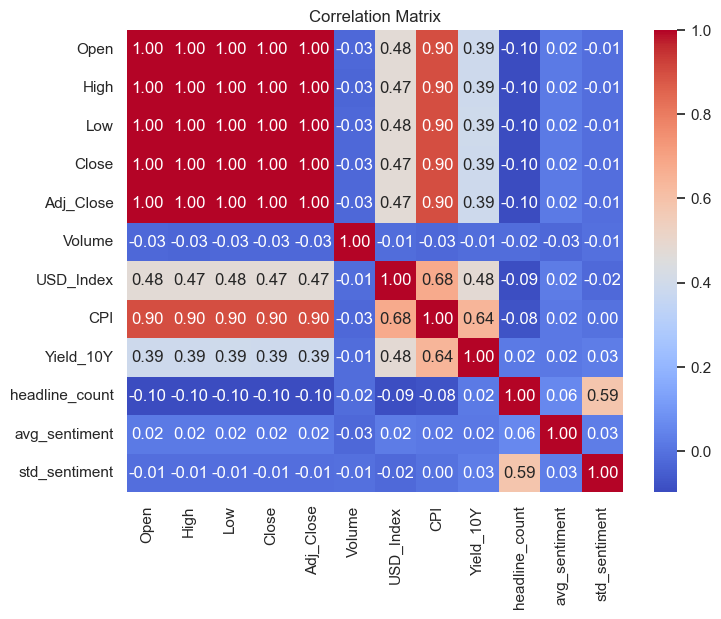

In [4]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

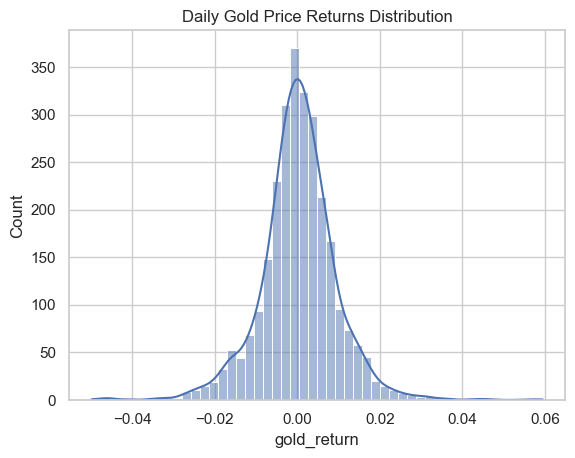

In [5]:
df["gold_return"] = df["Adj_Close"].pct_change()
sns.histplot(df["gold_return"].dropna(), bins=50, kde=True)
plt.title("Daily Gold Price Returns Distribution")
plt.show()

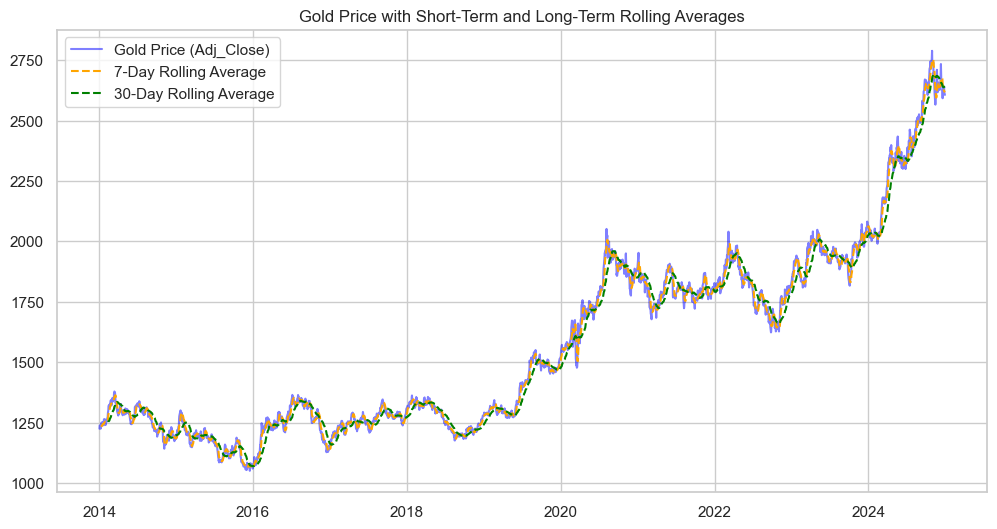

In [6]:
# --- Rolling Averages ---
# Define rolling window size (e.g., 7 days for short-term trends, 30 days for long-term)
short_window = 7
long_window = 30

# Compute short-term and long-term rolling averages
df["gold_rolling_short"] = df["Adj_Close"].rolling(window=short_window).mean()
df["gold_rolling_long"] = df["Adj_Close"].rolling(window=long_window).mean()

# Plot the rolling averages
plt.figure(figsize=(12, 6))
plt.plot(df["Adj_Close"], label="Gold Price (Adj_Close)", color="blue", alpha=0.5)
plt.plot(df["gold_rolling_short"], label=f"{short_window}-Day Rolling Average", color="orange", linestyle="--")
plt.plot(df["gold_rolling_long"], label=f"{long_window}-Day Rolling Average", color="green", linestyle="--")
plt.title("Gold Price with Short-Term and Long-Term Rolling Averages")
plt.legend(loc="best")
plt.show()


In [7]:
# --- Lag Features ---
# Define the lag period (e.g., 1-day, 7-day, 30-day lags)
lags = [1, 7, 30]

# Create lagged features for each selected column
for lag in lags:
    df[f"gold_lag_{lag}"] = df["Adj_Close"].shift(lag)
    df[f"usd_index_lag_{lag}"] = df["USD_Index"].shift(lag)
    df[f"sentiment_lag_{lag}"] = df["avg_sentiment"].shift(lag)

# Preview the DataFrame with lag features
df[[f"gold_lag_{lag}" for lag in lags] + 
   [f"usd_index_lag_{lag}" for lag in lags] + 
   [f"sentiment_lag_{lag}" for lag in lags]].head()

,gold_lag_1,gold_lag_7,gold_lag_30,usd_index_lag_1,usd_index_lag_7,usd_index_lag_30,sentiment_lag_1,sentiment_lag_7,sentiment_lag_30
Date,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,1225.0,NaN,NaN,80.63,NaN,NaN,-0.4404,NaN,NaN
2014-01-06,1238.4,NaN,NaN,80.79,NaN,NaN,0.0000,NaN,NaN
2014-01-07,1237.8,NaN,NaN,80.65,NaN,NaN,0.7430,NaN,NaN
2014-01-08,1229.4,NaN,NaN,80.83,NaN,NaN,0.0000,NaN,NaN


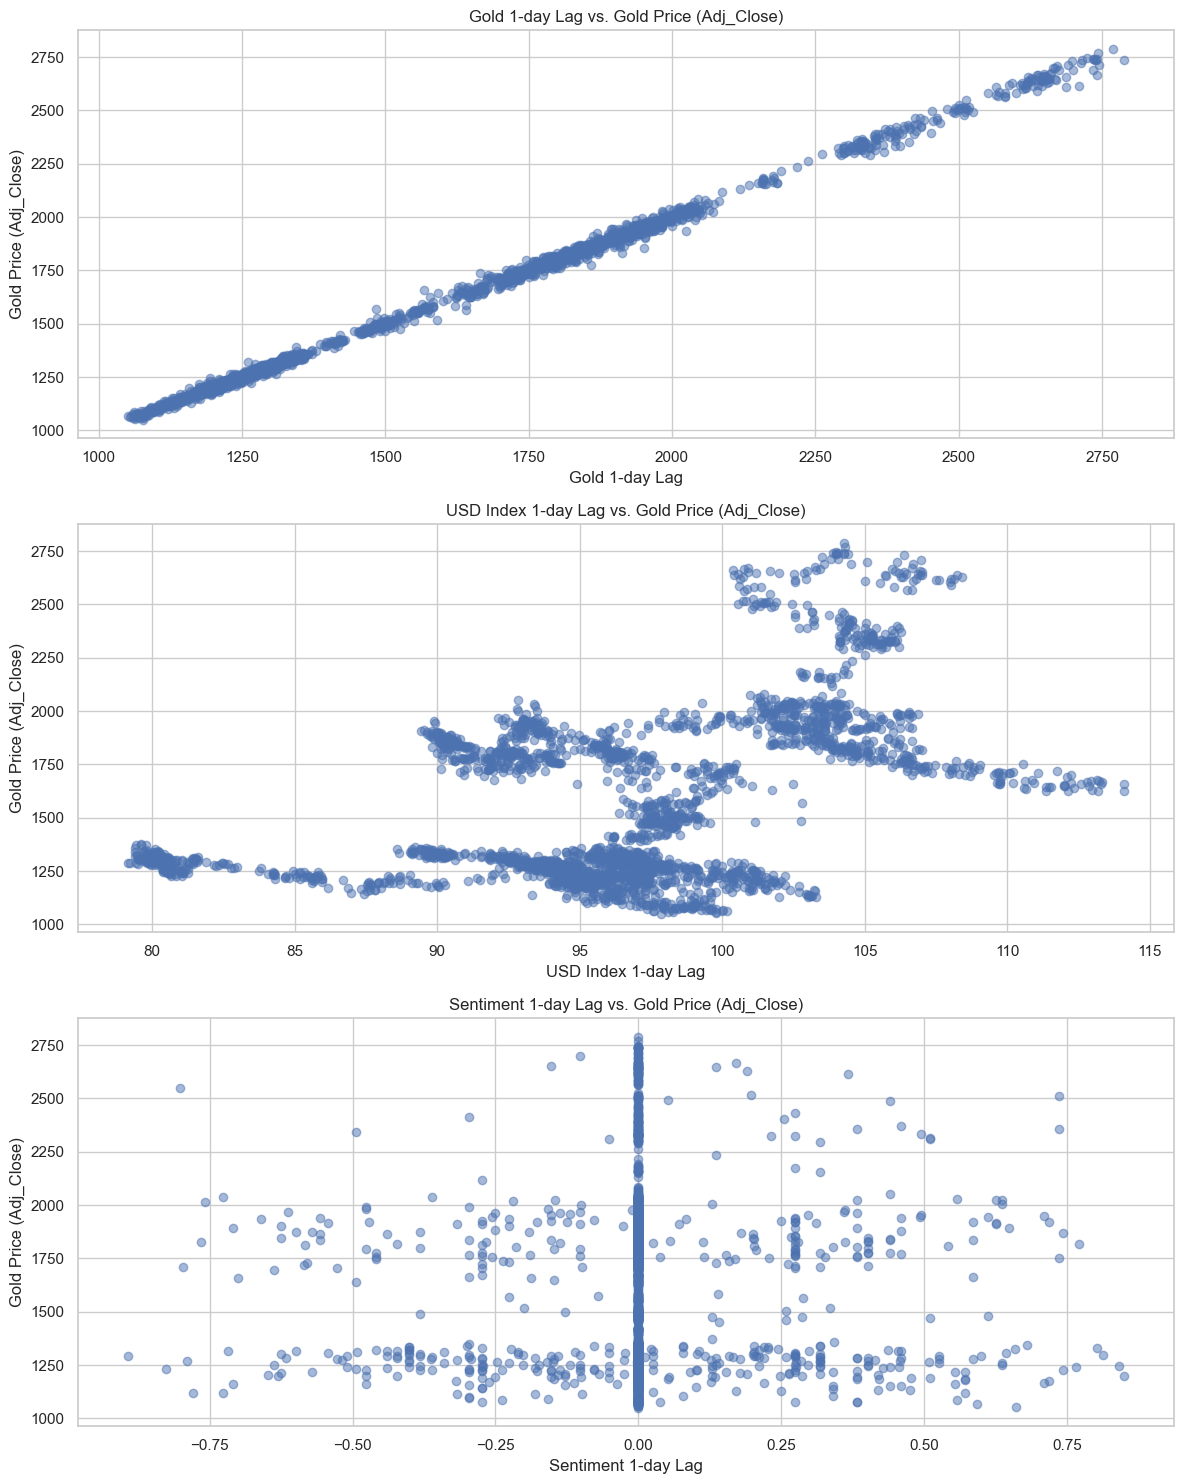

In [8]:
# Plot lagged features vs. gold price (Adj_Close)
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Gold lags vs Adj_Close
axes[0].scatter(df["gold_lag_1"], df["Adj_Close"], alpha=0.5)
axes[0].set_title("Gold 1-day Lag vs. Gold Price (Adj_Close)")
axes[0].set_xlabel("Gold 1-day Lag")
axes[0].set_ylabel("Gold Price (Adj_Close)")

# USD Index lags vs Adj_Close
axes[1].scatter(df["usd_index_lag_1"], df["Adj_Close"], alpha=0.5)
axes[1].set_title("USD Index 1-day Lag vs. Gold Price (Adj_Close)")
axes[1].set_xlabel("USD Index 1-day Lag")
axes[1].set_ylabel("Gold Price (Adj_Close)")

# Sentiment lags vs Adj_Close
axes[2].scatter(df["sentiment_lag_1"], df["Adj_Close"], alpha=0.5)
axes[2].set_title("Sentiment 1-day Lag vs. Gold Price (Adj_Close)")
axes[2].set_xlabel("Sentiment 1-day Lag")
axes[2].set_ylabel("Gold Price (Adj_Close)")

plt.tight_layout()
plt.show()


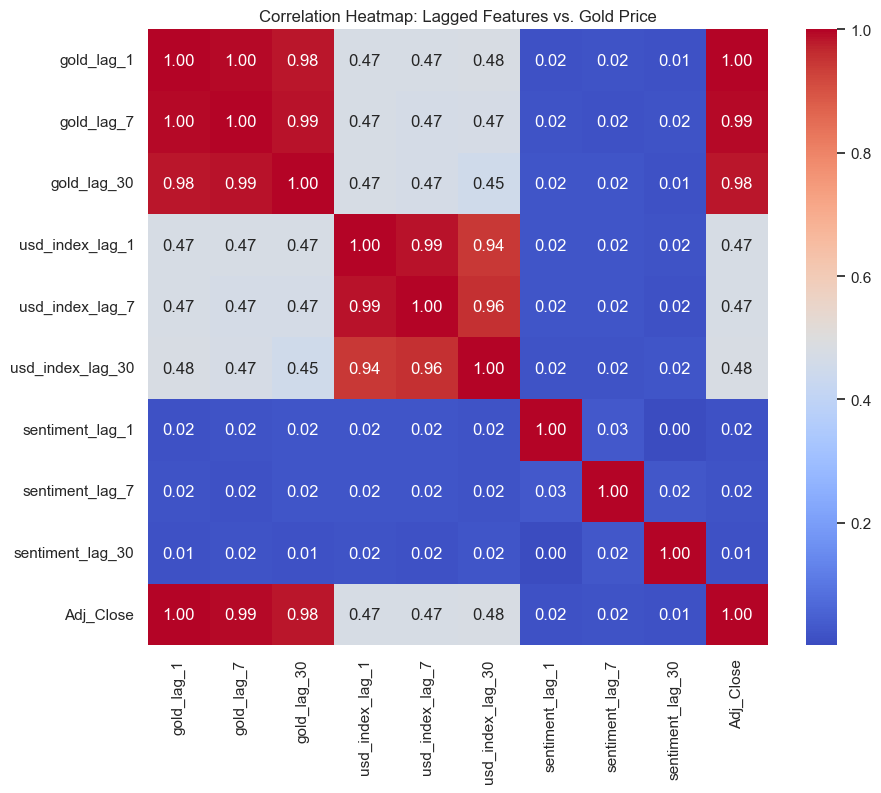

In [9]:
# Correlation heatmap for lagged variables
lagged_features = [f"gold_lag_{lag}" for lag in lags] + \
                  [f"usd_index_lag_{lag}" for lag in lags] + \
                  [f"sentiment_lag_{lag}" for lag in lags]

plt.figure(figsize=(10, 8))
sns.heatmap(df[lagged_features + ["Adj_Close"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Lagged Features vs. Gold Price")
plt.show()


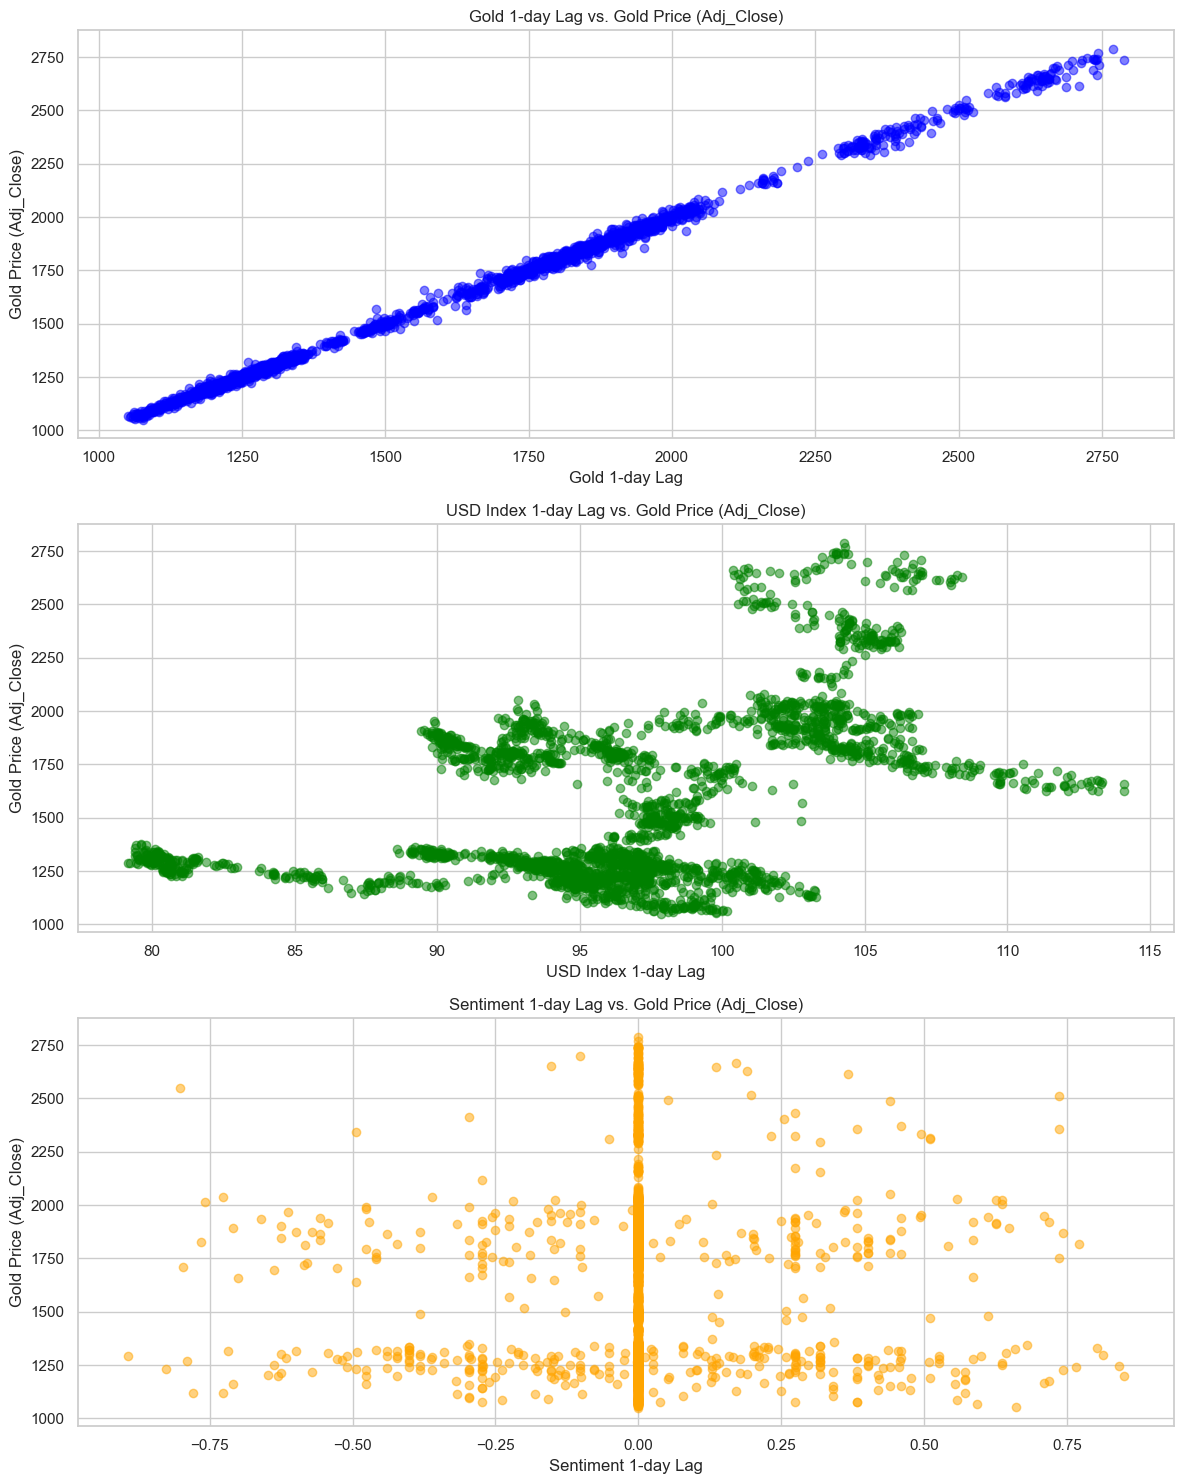

In [11]:
# Plot lagged features vs. gold price (Adj_Close)
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Gold lags vs Adj_Close
axes[0].scatter(df["gold_lag_1"], df["Adj_Close"], alpha=0.5, color="blue")
axes[0].set_title("Gold 1-day Lag vs. Gold Price (Adj_Close)")
axes[0].set_xlabel("Gold 1-day Lag")
axes[0].set_ylabel("Gold Price (Adj_Close)")

# USD Index lags vs Adj_Close
axes[1].scatter(df["usd_index_lag_1"], df["Adj_Close"], alpha=0.5, color="green")
axes[1].set_title("USD Index 1-day Lag vs. Gold Price (Adj_Close)")
axes[1].set_xlabel("USD Index 1-day Lag")
axes[1].set_ylabel("Gold Price (Adj_Close)")

# Sentiment lags vs Adj_Close
axes[2].scatter(df["sentiment_lag_1"], df["Adj_Close"], alpha=0.5, color="orange")
axes[2].set_title("Sentiment 1-day Lag vs. Gold Price (Adj_Close)")
axes[2].set_xlabel("Sentiment 1-day Lag")
axes[2].set_ylabel("Gold Price (Adj_Close)")

plt.tight_layout()
plt.show()


In [16]:
# Forward fill missing values (fill NaN with previous valid data)
df.ffill(inplace=True)
# Backward fill missing values (fill NaN with next valid data)
df.bfill(inplace=True)


                    Missing Values  Percentage
Open                             0         0.0
High                             0         0.0
Low                              0         0.0
Close                            0         0.0
Adj_Close                        0         0.0
Volume                           0         0.0
USD_Index                        0         0.0
CPI                              0         0.0
Yield_10Y                        0         0.0
headline_count                   0         0.0
avg_sentiment                    0         0.0
std_sentiment                    0         0.0
gold_return                      0         0.0
gold_rolling_short               0         0.0
gold_rolling_long                0         0.0
gold_lag_1                       0         0.0
usd_index_lag_1                  0         0.0
sentiment_lag_1                  0         0.0
gold_lag_7                       0         0.0
usd_index_lag_7                  0         0.0
sentiment_lag

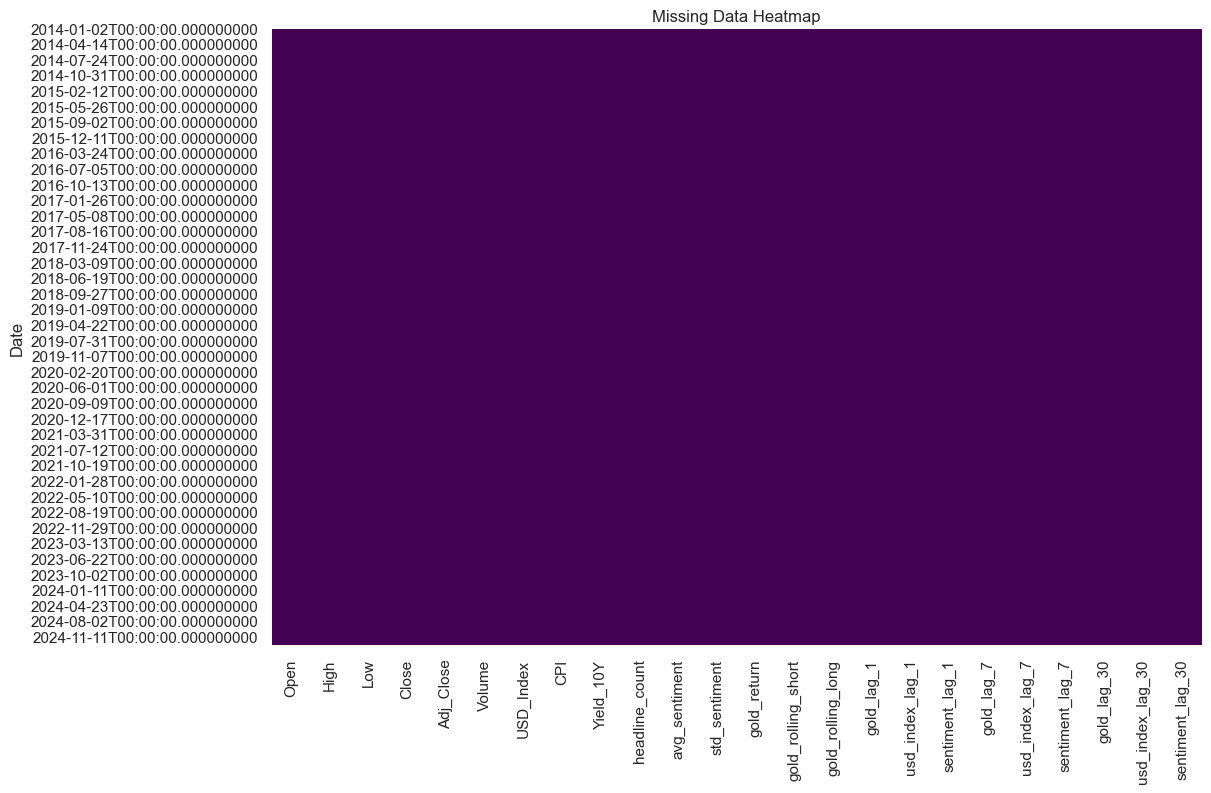

In [17]:
# Check the total number of missing values per column
missing_data = df.isnull().sum()

# Check the percentage of missing values per column
missing_percentage = (missing_data / len(df)) * 100

# Display columns with missing data and their counts/percentage
missing_info = pd.DataFrame({"Missing Values": missing_data, "Percentage": missing_percentage})
print(missing_info)

# Optional: Visualize missing data using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis", cbar_kws={'label': 'Missing Data'})
plt.title("Missing Data Heatmap")
plt.show()


In [18]:
from datetime import datetime
from pathlib import Path

# Create output folder if it doesn't exist
output_dir = Path("../../dataset/processed")
output_dir.mkdir(parents=True, exist_ok=True)

# Generate filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = output_dir / f"merged_gold_macro_final_{timestamp}.csv"

# Save the DataFrame
df.to_csv(output_path, index=True)  # Ensure 'Date' is the index in the output file
print(f"✅ Processed dataset saved to: {output_path}")

✅ Processed dataset saved to: ../../dataset/processed/merged_gold_macro_final_20250331_170349.csv
